**Course**:    Social graphs and interactions

**No.**:       02805

**Students**:  s204255 & s204122

**Date**:      11th December 2024



# Imports

In [58]:
import requests
import json
from bs4 import BeautifulSoup
import networkx as nx
import re
from matplotlib import pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from matplotlib.colors import Normalize

# Load statics

In [59]:
# Load stored course-site HTMLs
with open('valid_courses.json') as f:
    valid_courses = json.load(f)

# Load department color mapping
with open('department_colors.json') as f:
    department_colors = json.load(f)

# Load department names
with open('department_names.json') as f:
    department_names = json.load(f)

# Create graph

## Add nodes

In [60]:
# Initialize directd graph
G = nx.DiGraph()

# Go through each course
for course_num in valid_courses:
    department = course_num[:2] 
    G.add_node(course_num,
               course_num=course_num,
               page=valid_courses[course_num],
               department=department, 
               color=department_colors[department],
               department_name=department_names[department])

## Add edges

In [61]:
for course_num in valid_courses:

    # Initialize BeautifulSoup object
    page = G.nodes[course_num]['page']
    soup = BeautifulSoup(page, 'html.parser')

    # Define the search pattern to match both "Academic prerequisites" and "Mandatory prerequisites"
    search_pattern = r"(Academic prerequisites|Mandatory Prerequisites)"
    
    # Find the label element that matches the pattern
    label = soup.find('label', string=re.compile(search_pattern))
    if label is None:
        continue  # Skip if no label is found
    
    # Get the parent element that contains the label and prerequisites
    parent = label.find_parent().find_parent()
    
    # Get the second <td> (assuming it contains the prerequisites text)
    prerequisite = parent.find_all('td')[1].text

    # Remove whitespace and line breaks
    prerequisite = prerequisite.replace('\r', ' ').replace('\n', ' ')

    # Extract 5-digit course numbers
    prerequisites = set(re.findall(r'\d{5}', prerequisite))
    
    # Add edges to the graph for valid prerequisites
    for prerequisite in prerequisites:
        if prerequisite in G.nodes:
            if prerequisite != course_num:  # Skip self-loops
                G.add_edge(prerequisite, course_num)


## Add text attributes

In [62]:
for node in G.nodes:
    
    ### Initialize BeuatifulSoup object
    page = G.nodes[node]['page']
    soup = BeautifulSoup(page, 'html.parser')
    
    ### Add title to node
    title = soup.title.text
    cleaned = ' '.join(title.strip().split())[6:]
    G.nodes[node]['course_title'] = cleaned
    
    ### Add course text to node (General course objectives + Learning objectives + Content)
    div = soup.find('div', string=re.compile("General course objectives")).parent(string=True)
    
    remove_indeces = []
    for d, text in enumerate(div):
        if text in ["General course objectives", "Learning objectives", "Content", "Last updated", "\r\nA student who has met the objectives of the course will be able to:\r\n\r\n"]:
            remove_indeces.append(d)
    
    new_div = [div[i] for i in range(len(div)) if i not in remove_indeces]
    text = ' '.join(new_div[:-1]).replace('\r', ' ').replace('\n', '')
    cleaned = ' '.join(text.strip().split())
    G.nodes[node]['course_text'] = cleaned  
    G.nodes[node]['text_size'] = len(cleaned) 
    G.nodes[node]['word_count'] = len(cleaned.split())

    

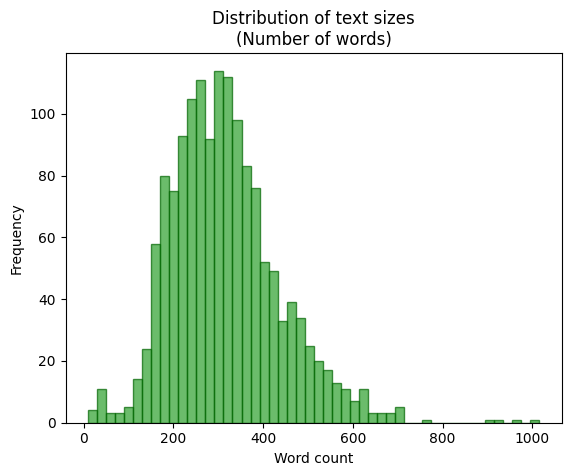

In [63]:
# plot distribution of text sizes
text_sizes = [G.nodes[node]['word_count'] for node in G.nodes]
plt.hist(text_sizes, bins=50, color='C2', alpha=0.7, edgecolor='darkgreen')
plt.title('Distribution of text sizes\n(Number of words)')
plt.xlabel('Word count')
plt.ylabel('Frequency')
plt.show()

# Get evaluations and grades

In [64]:
# Evaluations
with open('eval_scores.json') as f:
    eval_scores = json.load(f)

# Grades
with open('grade_scores.json') as f:
    grade_scores = json.load(f)

In [65]:
# Apply evaluation and grade attributes
for course_num in grade_scores:
    G.nodes[course_num]['eval_scores'] = eval_scores[course_num]
    G.nodes[course_num]['grade_scores'] = grade_scores[course_num]
 

for node in G.nodes:
    if node == '41392':
        continue
    eval_scores = G.nodes[node].get('eval_scores', None)
    if eval_scores:
        learned_a_lot = eval_scores[0]
        time_used = eval_scores[5]
        
        # Calculate the fairness score
        fairness_score = ((learned_a_lot / time_used) - 0.2) / 4.8
        
        # Add the fairness score as a node attribute
        G.nodes[node]['fairness'] = fairness_score

    
# Remove nodes from G that do not have evaluation scores
G = G.subgraph([node for node in G.nodes if 'eval_scores' in G.nodes[node]])
# Remove nodes from G with empty evaluation scores
G = G.subgraph([node for node in G.nodes if G.nodes[node]['eval_scores']])

# Degree distribution

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


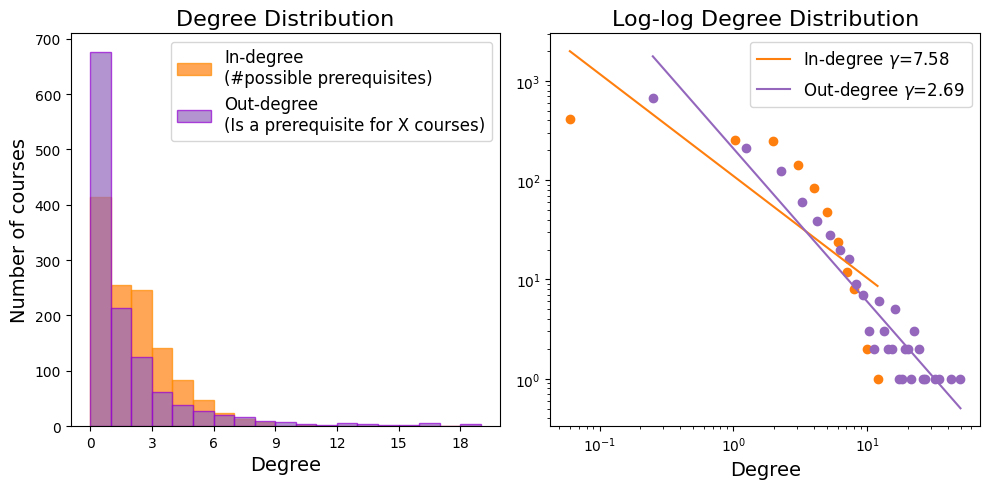

In [66]:
# Calculate in- and out-degrees
in_degrees = [G.in_degree(n) for n in G.nodes]
out_degrees = [G.out_degree(n) for n in G.nodes]

# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Combined in- and out-degree distributions in one plot
bins_range = range(min(min(in_degrees), min(out_degrees)), max(max(in_degrees), max(out_degrees)) + 2)
bins_range = range(0, 20)

axs[0].hist(in_degrees, bins=bins_range, color='C1', alpha=0.7, edgecolor='darkorange', label='In-degree\n(#possible prerequisites)')
axs[0].hist(out_degrees, bins=bins_range, color='C4', alpha=0.7, edgecolor='darkviolet', label='Out-degree\n(Is a prerequisite for X courses)')
axs[0].set_xlabel('Degree', fontsize=14)
axs[0].set_ylabel('Number of courses', fontsize=14)
axs[0].set_title('Degree Distribution', fontsize=16)
axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
axs[0].legend(fontsize=12)

# Log-log scatter plots for in-degree and out-degree distributions
def compute_loglog(degrees, label, color, ax):
    hist, bin_edges = np.histogram(degrees, bins=100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Filter out zero values
    valid = (hist > 0)
    x = bin_centers[valid]
    y = hist[valid]

    # Scatter plot
    ax.scatter(x, y, marker='o', color=color)

    # Power-law fit
    import powerlaw
    fit = powerlaw.Fit(degrees)

    # Fit line in log-log space
    log_x = np.log(x)
    log_y = np.log(y)
    m, b = np.polyfit(log_x, log_y, 1)  # Linear fit to log-log data
    ax.plot(x, np.exp(b) * x**m, '-', label=f'{label} $\gamma$={fit.alpha:.2f}', color=color)

    return fit.alpha

# Plot in-degree and out-degree log-log distributions
gamma_in = compute_loglog(in_degrees, 'In-degree', 'C1', axs[1])
gamma_out = compute_loglog(out_degrees, 'Out-degree', 'C4', axs[1])

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Degree', fontsize=14)
axs[1].set_title('Log-log Degree Distribution', fontsize=16)
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()


# Plotting

## Test partitionings

In [67]:
def heuristic_pm_2(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Predecessors and the predecessors of predecessors
    3. Successors and the successors of successors 
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add predecessors and their predecessors
        for pred in graph.predecessors(node):
            community.add(pred)
            community.update(graph.predecessors(pred))
        
        # Add successors and their successors
        for succ in graph.successors(node):
            community.add(succ)
            community.update(graph.successors(succ))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 15 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 15}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)
    
    # replace nodes with indeces
    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


def heuristic_pm_1(graph):
    '''
    For each node, add a community that consists of:
    1. The node itself
    2. Immediate predecessors
    3. Immediate successors
    '''
    communities = defaultdict(list)  # Store communities indexed by node
    
    for node in graph.nodes:
        # Initialize the community with the node itself
        community = set([node])
        
        # Add immediate predecessors
        community.update(graph.predecessors(node))
        
        # Add immediate successors
        community.update(graph.successors(node))
        
        # Convert the community set to a list and assign it
        communities[node] = list(community)
    
    # remove communities with more than 9 courses
    communities = {k: v for k, v in communities.items() if len(v) <= 9}
    unique_courses = set()
    for community in communities.values():
        unique_courses.update(community)

    # replace nodes with indeces
    _communities = {}
    for i, key in enumerate(communities.keys()):
        _communities[i] = communities[key].copy()

    return dict(_communities)


In [68]:
# Method 4 - Heuristic ± 1 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_1(H)

In [69]:
# Method 5 - Heuristic ± 2 (directed graph with constraints)
H = G.copy()
communities = heuristic_pm_2(H)

In [ ]:
# The number of communities
print(f'Number of communities: {len(communities)}')

Number of communities: 1112


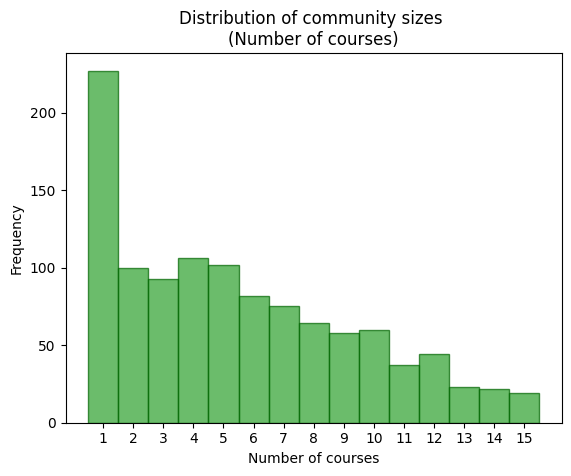

In [106]:
# plot distribution of value sizes
value_sizes = [len(communities[c]) for c in communities]
plt.hist(value_sizes, bins=range(min(value_sizes), max(value_sizes) + 2), color='C2', alpha=0.7, edgecolor='darkgreen',align='left')
plt.title('Distribution of community sizes \n(Number of courses)')
plt.xlabel('Number of courses')
plt.ylabel('Frequency')
plt.xticks(range(min(value_sizes), max(value_sizes) + 1))  # Add ticks for each number of courses
plt.show()

## Distribution of fairness

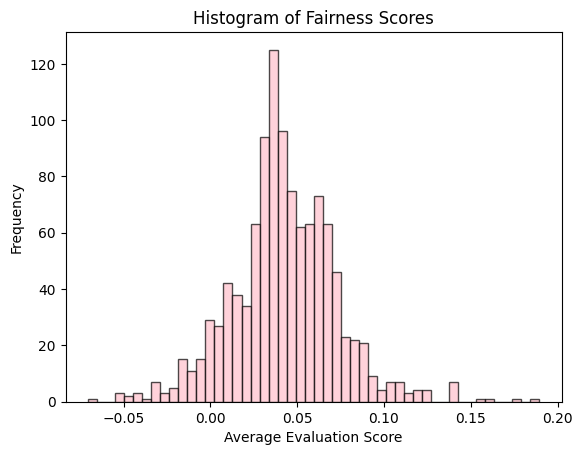

In [71]:

# Create a new dictionary to store the average evaluation scores
average_eval_scores = {}

# Iterate through each community
for community_id, courses in communities.items():
    if community_id == 726: # Skip the community with the course 41392
        continue
    average_learned_a_lot = 0
    average_time_used = 0
    count_number_of_grades = 0

    for course in courses:
        average_learned_a_lot += G.nodes[course]['eval_scores'][0]
        average_time_used += G.nodes[course]['eval_scores'][5]

    average_learned_a_lot /= len(courses)
    average_time_used /= len(courses)
    
    # Worst
    # learn little, study a lot, 1/5 = 0.2
    # Best
    # learn a lot, study little, 5/1 = 5

    average_eval_scores[community_id] = ((average_learned_a_lot / average_time_used)-0.2)/4.8 # The number is between 0 and 4.8

# Filter out null values from average_eval_scores
filtered_scores = [score-(0.8/4.8) for score in average_eval_scores.values() if score is not None]

# Plot the histogram
plt.hist(filtered_scores, bins=50, color='pink', alpha=0.7, edgecolor='black')
plt.title('Histogram of Fairness Scores')
plt.xlabel('Average Evaluation Score')
plt.ylabel('Frequency')
plt.show()

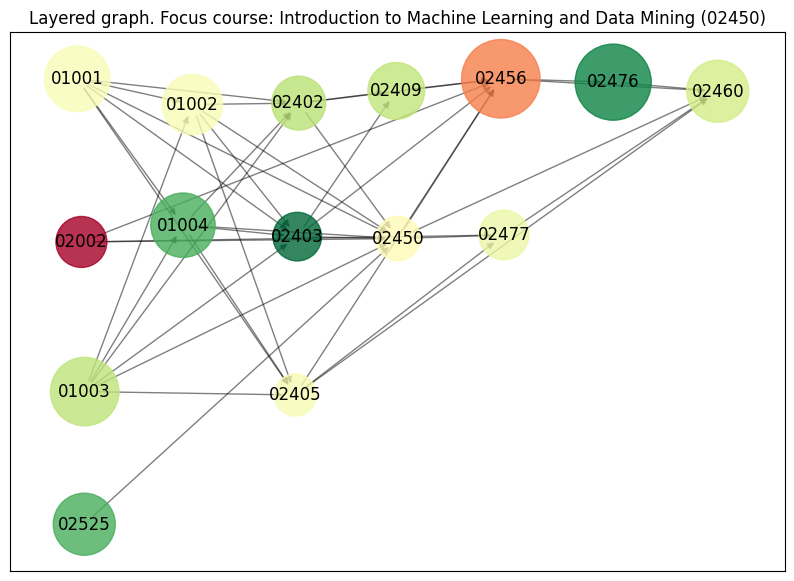

In [72]:
def plot_depth_based_layered_graph(community, graph, figsize1=15, figsize2=8):
    """
    Plot a layered graph where nodes are placed in layers based on depth
    from the root nodes in the directed subgraph.
    Dynamically reassigns nodes to fix layering violations.
    """
    # Create a directed subgraph from the community
    subgraph = graph.subgraph(community)
    
    # Ensure all community nodes are in the subgraph
    subgraph_nodes = set(subgraph.nodes)
    community = [node for node in community if node in subgraph_nodes]
    
    # Identify root nodes (nodes with in-degree 0)
    roots = [node for node in community if subgraph.in_degree(node) == 0]
    
    # Initialize layers, visited set, and node-to-layer mapping
    layers = defaultdict(list)
    node_to_layer = {}
    visited = set()
    
    # Assign layers iteratively
    def assign_layer(node, current_layer):
        # If the node is already visited, reassign it to a deeper layer if needed
        if node in visited:
            existing_layer = node_to_layer[node]
            if existing_layer < current_layer:
                # Move the node to the current deeper layer
                if node in layers[existing_layer]:
                    layers[existing_layer].remove(node)
                layers[current_layer].append(node)
                node_to_layer[node] = current_layer
            return
        
        # Add the node to the current layer
        layers[current_layer].append(node)
        node_to_layer[node] = current_layer
        visited.add(node)
        
        # Process successors
        for successor in subgraph.successors(node):
            assign_layer(successor, current_layer + 1)
    
    # Assign layers starting from each root
    for root in roots:
        assign_layer(root, 0)
    
    # Ensure layering is consistent by reprocessing predecessors
    for node in community:
        # Skip nodes not yet assigned a layer
        if node not in node_to_layer:
            continue
        
        node_layer = node_to_layer[node]
        for predecessor in subgraph.predecessors(node):
            predecessor_layer = node_to_layer.get(predecessor, -1)
            if predecessor_layer >= node_layer:
                # Move the node to a deeper layer
                if node in layers[node_layer]:
                    layers[node_layer].remove(node)
                new_layer = predecessor_layer + 1
                layers[new_layer].append(node)
                node_to_layer[node] = new_layer
    
    # Assign positions for all nodes in the subgraph
    pos = {}
    for i, (layer, nodes) in enumerate(sorted(layers.items())):
        for j, node in enumerate(nodes):
            pos[node] = (i+np.random.rand()/10, -j+np.random.rand()/5)
    
    # Check for unpositioned nodes and add them to a separate layer
    unpositioned_nodes = [node for node in subgraph.nodes if node not in pos]
    if unpositioned_nodes:
        last_layer = max(pos.values(), default=(0, 0))[0] + 1
        for j, node in enumerate(unpositioned_nodes):
            pos[node] = (last_layer, -j)
    
    # Determine the center node based on degree
    center_node = max(subgraph.nodes, key=lambda x: subgraph.degree(x))
    
    # Draw the graph
    plt.figure(figsize=(figsize1, figsize2))
    
    # Node color based on grade score and node size based on fairness score
    #node_color = [(G.nodes[node]['grade_scores'][2]+3)/15 for node in subgraph.nodes]
    #node_size = [(200*((G.nodes[node]['fairness'])))**2 for node in subgraph.nodes]

    # Node color based on fairness score and node size based on grade score
    node_color = [G.nodes[node]['fairness'] for node in subgraph.nodes]
    node_size = [4000*((G.nodes[node]['grade_scores'][2]+3)/15)**2 for node in subgraph.nodes]

    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color=node_color, cmap="RdYlGn", alpha=0.8)

    nx.draw_networkx_edges(subgraph, pos, alpha=0.5)

    labels = {}
    for node in subgraph.nodes:
        #label = graph.nodes[node].get('course_title', str(node))
        label = graph.nodes[node].get('course_num', str(node))
        if len(label) > 20:
            split = label.split(' ')
            mid = len(split) // 2
            labels[node] = ' '.join(split[:mid]) + '\n' + ' '.join(split[mid:])
        else:
            labels[node] = label
    nx.draw_networkx_labels(subgraph, pos, labels, font_size=12)
    

    plt.title(f"Layered graph. Focus course: {graph.nodes[center_node].get('course_title', str(center_node))} ({center_node})")
    plt.show()

plot_depth_based_layered_graph(communities[96], G,10,7)

### Department only

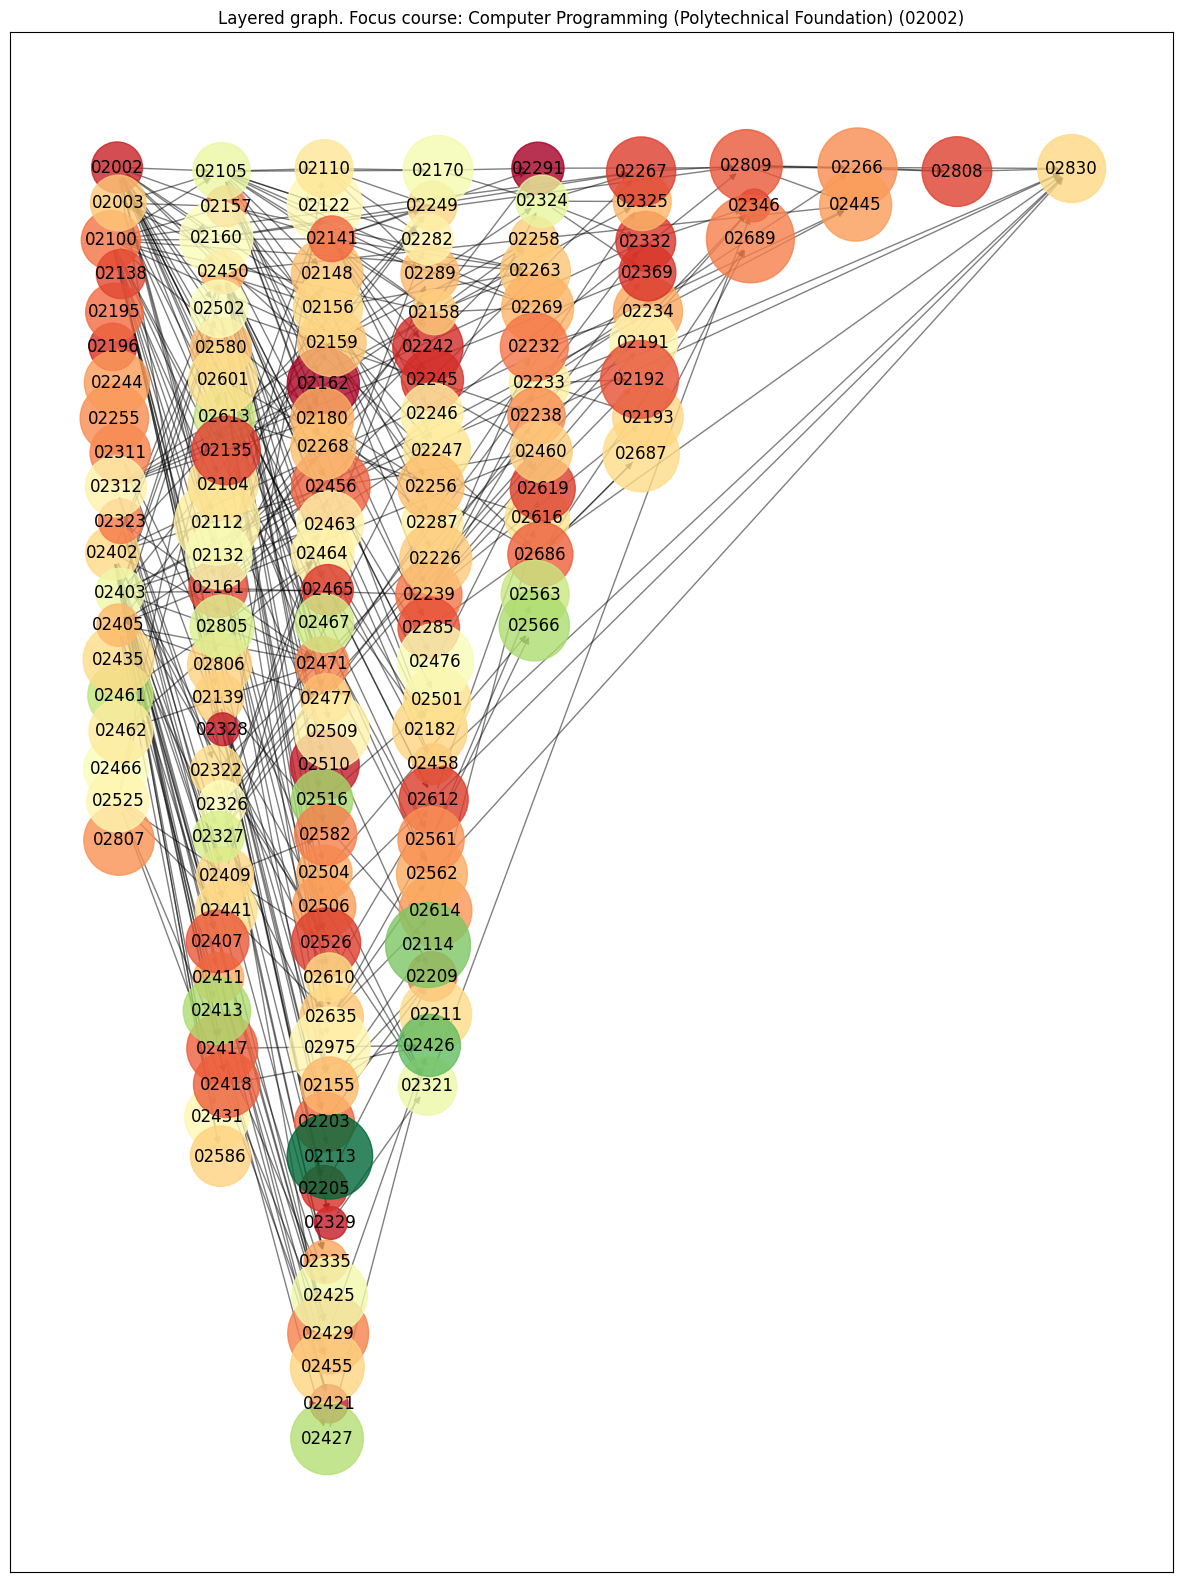

In [73]:
# get all courses from department
department = '02'

courses = []
for node in G.nodes:
    if G.nodes[node]['department'] == department and G.nodes[node]['grade_scores'][2] is not None:
        courses.append(node)

plot_depth_based_layered_graph(courses, G, 15,20)

# Summarize communities

In [74]:
class CommunitiesSummary():
    def __init__(self, graph, communities):
        self.graph = graph
        self.communities = communities
    
    # Number of communities
    def __len__(self):
        return len(self.communities)
    
    # Average grade
    def avg_grade(self, community_index):
        grades = []
        for course in self.communities[community_index]:
            grade = self.graph.nodes[course]['grade_scores'][2]
            
            # Only add if the course uses the 7-scale grading system
            if grade is not None:
                grades.append(grade)
        
        # Return None if no grades were found
        if len(grades) == 0:
            return None
        
        # Return the average grade
        return sum(grades) / len(grades)
    
    # Average pass rate
    def avg_pass_rate(self, community_index):
        pass_rates = []
        for course in self.communities[community_index]:
            grade_scores = self.graph.nodes[course]['grade_scores']
            pass_rates.append(grade_scores[1] / grade_scores[0])
       
        # Return average pass rate 
        return sum(pass_rates) / len(pass_rates)
    
    # Average evaluation score
    def avg_evals(self, community_index):
        
        all_evals = []
        for i in range(6):
            evals = []
            for course in self.communities[community_index]:
                eval_score = self.graph.nodes[course]['eval_scores'][i]
                evals.append(eval_score)
            all_evals.append(sum(evals)/len(evals))
        
        return all_evals
    
    # Get single community stats
    def __getitem__(self, index):
        community = self.communities[index]
        return {
            'index': index,
            'size': len(community),
            'courses': community,
            'courses_titles': [self.graph.nodes[course]['course_title'] for course in community],
            'avg_grade': self.avg_grade(index),
            'avg_pass_rate': self.avg_pass_rate(index),
            'avg_evals': self.avg_evals(index),
            'all_text': ' '.join([self.graph.nodes[course]['course_text'] for course in community])
        }
        
    # Get all communities that includes course
    def get_communities(self, course):
        return [index for index, community in self.communities.items() if course in community]
   
        
COM = CommunitiesSummary(G, communities)

In [75]:
outgoing_nodes = list(G.successors('02405'))
print(outgoing_nodes)

['02249', '02407', '02421', '02456', '02460', '02471', '02477', '02502', '02586', '02975', '22052', '30405', '34231', '41275', '41969', '42417']


In [76]:
includes_course = COM.get_communities('02405')
print("Size:", len(includes_course))
for i in includes_course:
    print(COM[i])
    print()

Size: 27
{'index': 45, 'size': 14, 'courses': ['02239', '01001', '02002', '02161', '02403', '01004', '01003', '02502', '02238', '02830', '02405', '02159', '01002', '02402'], 'courses_titles': ['Data Security', 'Mathematics 1a (Polytechnical foundation)', 'Computer Programming (Polytechnical Foundation)', 'Software Engineering 1', 'Introduction to Mathematical Statistics', 'Mathematics 1b (Polytechnical Foundation)', 'Mathematics 1a (Polytechnical foundation)', 'Image analysis', 'Biometric Systems', 'Advanced Project in Digital Media Engineering', 'Probability theory', 'Operating Systems', 'Mathematics 1b (Polytechnical Foundation)', 'Statistics (Polytechnical Foundation)'], 'avg_grade': 7.128571428571428, 'avg_pass_rate': 0.8732383015632356, 'avg_evals': [3.9662427033096983, 4.111467075124019, 3.666564939863203, 3.6355277345023285, 3.7476333678557303, 3.416612788166265], 'all_text': 'To give students an introduction to fundamental concepts in computer security and introduce central the

## Big pretty plots

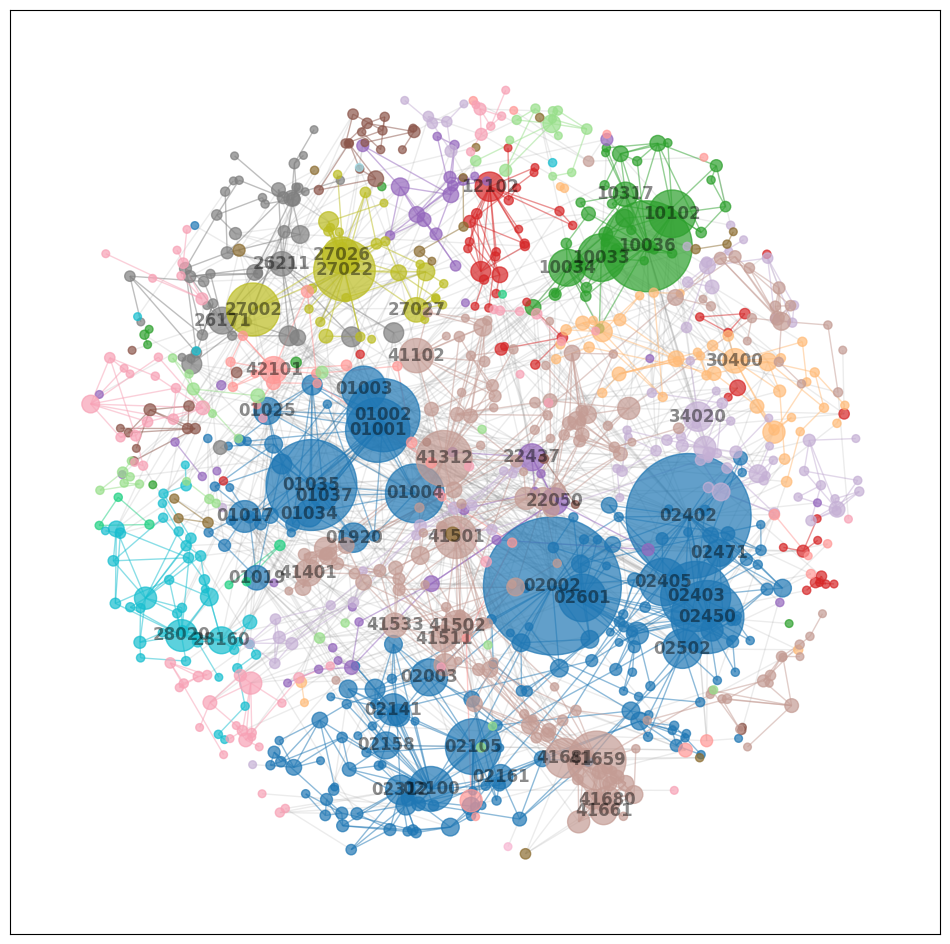

In [77]:
# Make undirected
H = G.to_undirected()

# Remove nodes with no edges
H = H.subgraph([node for node in H.nodes if H.degree(node) > 0])

# Get the largest connected component
largest_cc = max(nx.connected_components(H), key=len)
H = H.subgraph(largest_cc)

# Apply weights to edges
for edge in H.edges:
    if H.nodes[edge[0]]['department'] == H.nodes[edge[1]]['department']:
        H[edge[0]][edge[1]]['weight'] = 10
    else:
        H[edge[0]][edge[1]]['weight'] = 1

# Create layout
plt.figure(figsize=(12, 12))
pos = nx.forceatlas2_layout(H, 
                            seed=42,
                            dissuade_hubs=True,
                            scaling_ratio=1.5,
                            strong_gravity=True,
                            gravity=10,
                            weight='weight')

# Draw nodes
# Nodes are colored by department
# Nodes are scaled by log(degree)
node_sizes = [30+H.degree(node)**2.35 for node in H.nodes]
node_colors = [H.nodes[node]['color'] for node in H.nodes]
nx.draw_networkx_nodes(H, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7) 

# Draw edges
# Edges are colored by department if both nodes are in same department
edge_colors = [H.nodes[edge[0]]['color'] if H.nodes[edge[0]]['department']==H.nodes[edge[1]]['department'] else 'grey' for edge in H.edges]
alpha = [0.5 if H.nodes[edge[0]]['department']==H.nodes[edge[1]]['department'] else 0.15 for edge in H.edges]
nx.draw_networkx_edges(H, pos, edge_color=edge_colors, alpha=alpha)

# Draw labels if degree > 10
labels = {}
for node in H.nodes:
    if H.degree(node) > 10:
        labels[node] = H.nodes[node]['course_num']

nx.draw_networkx_labels(H, pos, labels=labels, font_size=12, font_color='black', font_weight='bold', alpha=0.45)

# Show plot
plt.show()

# Analyse words in departments

Purpose:

We want to look at the common words/wordclouds for each partition. 

### Get stopwords

In [78]:
# Download stopwords if you haven't already
nltk.download('stopwords')

# Get the list of English stopwords from nltk
nltk_stopwords = set(stopwords.words("english"))

# Define your own custom stopwords
with open("stopwords.txt", "r") as file:
    custom_stopwords = {line.strip() for line in file}

# Combine nltk stopwords with your custom stopwords
stop_words = nltk_stopwords.union(custom_stopwords)

# Define a function to remove stopwords from text
def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stein\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### TF-IDF

In [90]:

def generate_wordcloud(G, communities, stop_words=set(), max_words=200):
    """
    Generate and display word clouds for each community in the graph.

    Parameters:
        G (nx.Graph): The graph containing nodes with text attributes.
        communities (dict): A dictionary with partition IDs as keys and lists of nodes as values.
        stop_words (set): A set of stopwords to exclude from the word clouds.
        max_words (int): The maximum number of words to include in the word cloud.
    """
    
    # Dictionary to store the combined text for each community
    community_texts = defaultdict(list)
    
    # Aggregate text data for each community
    for partition_id, nodes in communities.items():
        for node in nodes:
            text = G.nodes[node].get("course_text", "")
            if text:
                text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
                words = text.lower().split()
                cleaned_words = [word for word in words if word not in stop_words]
                community_texts[partition_id].append(" ".join(cleaned_words))
    
    
    # Load image
    image = plt.imread("silhouette-of-a-person.png")
    image_gray = np.mean(image, axis=2)

    # Adjust threshold for the silhouette based on grayscale range
    if np.max(image_gray) > 1:  # If grayscale range is [0, 255]
        threshold = 128
    else:  # If grayscale range is [0, 1]
        threshold = 0.5

    # Create a mask
    mask = image_gray > threshold  # Boolean mask
    mask = mask.astype(int)*255  # Convert boolean mask to integers



    # Generate and display word clouds for each community
    for partition_id, documents in community_texts.items():
        # Combine all text documents into a single string
        combined_text = " ".join(documents)
        
        # Calculate TF-IDF for the community's text
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform([combined_text])
        feature_names = vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        
        # Create a dictionary of terms and their aggregated TF-IDF scores
        aggregated_scores = dict(zip(feature_names, tfidf_scores))
        
        # Generate the word cloud with a colormap
        wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=max_words, colormap="gist_heat_r", mask=mask, contour_width=1, contour_color="darkred").generate_from_frequencies(aggregated_scores)
        
        # Get the top 3 most connected courses in the partition
        node_degrees = [(node, G.degree(node)) for node in communities[partition_id]]
        top_3_nodes = sorted(node_degrees, key=lambda x: x[1], reverse=True)
        top_3_course_names = [G.nodes[node]["course_title"] for node, _ in top_3_nodes]
        title = "\n Courses: \n " + "\n".join(top_3_course_names)
        
        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word cloud for Community {partition_id} ")
        plt.show()

        print(title)

### Departmentwise

In [80]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    words = text.lower().split()
    # Remove stopwords
    cleaned_words = [word for word in words if word not in stop_words]
    return cleaned_words

# Populate color partitions with lists of words in each course description
color_partitions = defaultdict(list)
for node, data in G.nodes(data=True):
    color = data.get("color")  
    text = data.get("course_text")  
    
    if color and text:
        # Clean the course text and split into words
        cleaned_words = clean_text(text)
        color_partitions[color].append(cleaned_words)

# Map colors to department names using department_colors and department_names dictionaries
color_to_department = {}
for dept_code, color in department_colors.items():
    color_to_department[color] = department_names.get(dept_code, "Unknown Department")

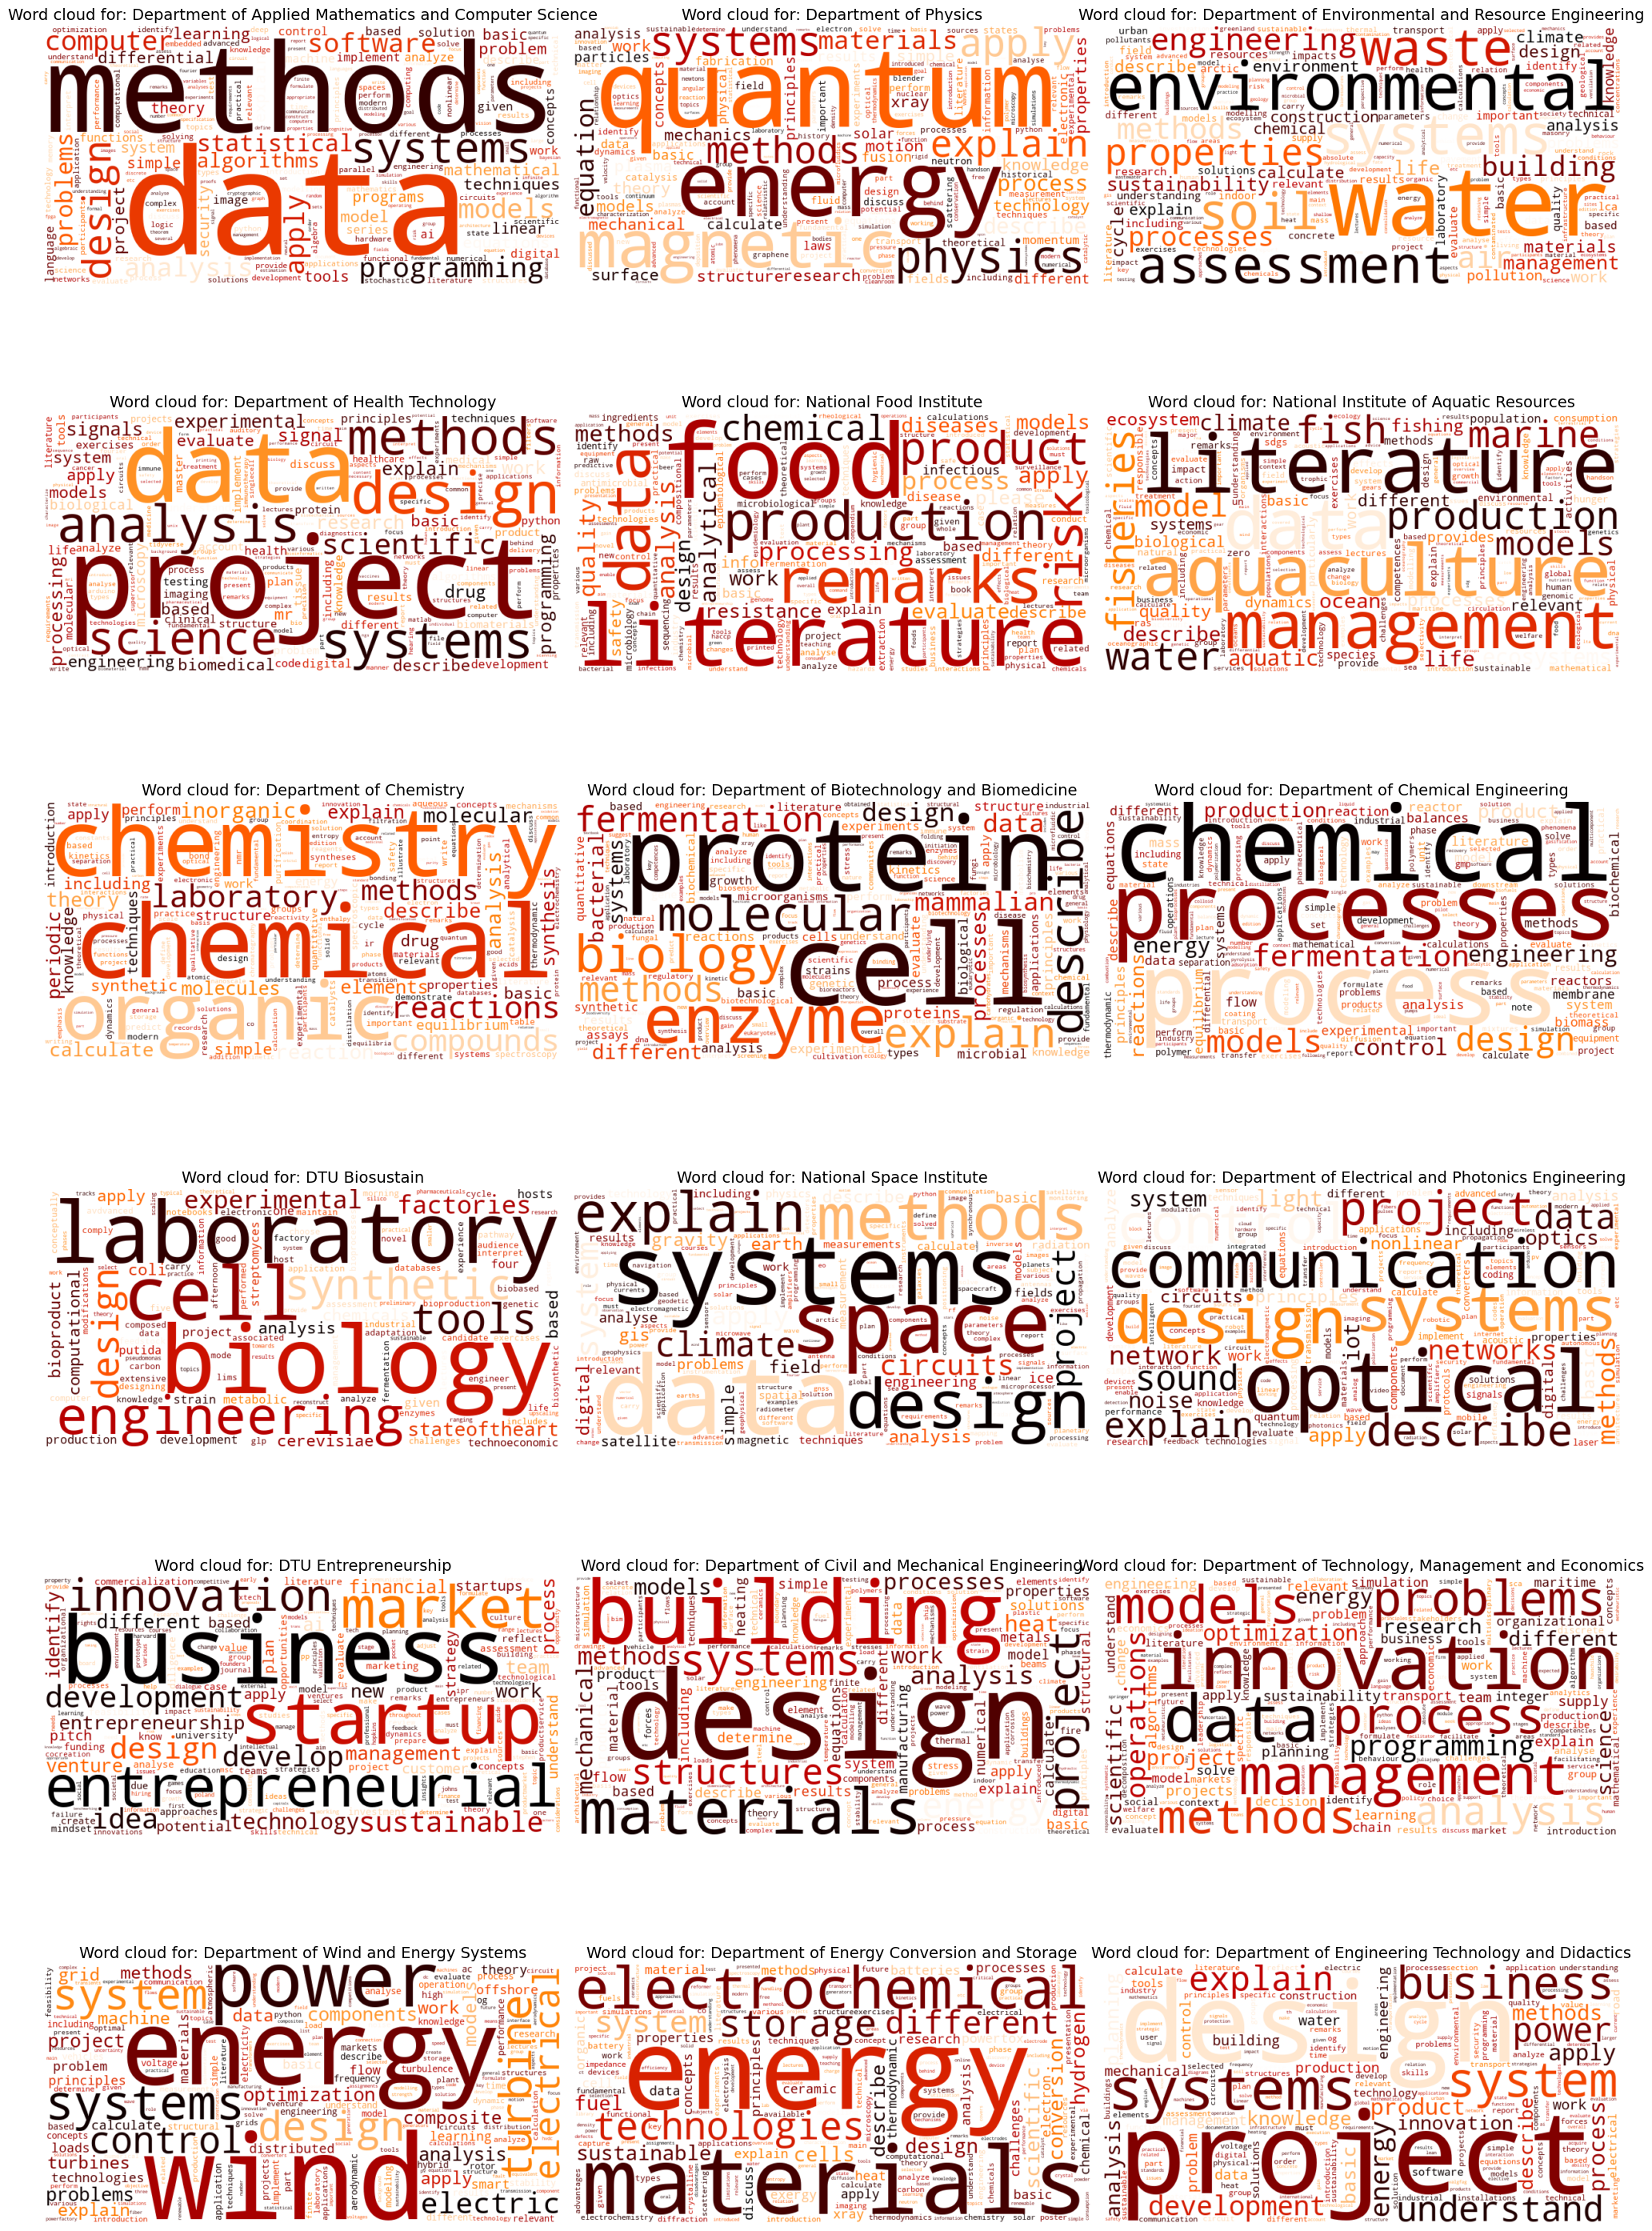

In [81]:
# Set the number of columns for the grid
n_columns = 3
n_rows = (len(color_partitions) + n_columns - 1) // n_columns

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_columns, figsize=(20, 5 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over color partitions and axes
for idx, (color, documents) in enumerate(color_partitions.items()):
    # Flatten list of lists into a single list of words for TF-IDF
    documents_flat = [' '.join(doc) for doc in documents]
    documents_flat = [doc for doc in documents_flat if doc]  # Remove empty documents

    # Calculate TF-IDF for the partition's documents
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents_flat)
    feature_names = vectorizer.get_feature_names_out()

    tfidf_scores = tfidf_matrix.sum(axis=0).A1 
    
    # Create a dictionary of terms and their aggregated TF-IDF scores
    aggregated_scores = dict(zip(feature_names, tfidf_scores))
    aggregated_scores = {term: score for term, score in aggregated_scores.items() if score > 0}

    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="gist_heat_r").generate_from_frequencies(aggregated_scores)
    
    department_name = color_to_department.get(color, "Unknown Department")
    
    ax = axes[idx]
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Word cloud for: {department_name}", fontsize=14)


for ax in axes[len(color_partitions):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Analyse words in communities

In [98]:
# Courses in the community 96
communities[96]


# Print course names from the community
for course in communities[96]:
    print(G.nodes[course]["course_title"])

Mathematics 1a (Polytechnical foundation)
Computer Programming (Polytechnical Foundation)
Bayesian machine learning
Introduction to Mathematical Statistics
Deep learning
Mathematics 1b (Polytechnical Foundation)
Machine Learning Operations
Probability theory
Mathematics 1b (Polytechnical Foundation)
Mathematics 1a (Polytechnical foundation)
Advanced Machine Learning
Statistics (Polytechnical Foundation)
Multivariate Statistics
Introduction to Machine Learning and Data Mining
Introduction to Mathematics and Technology


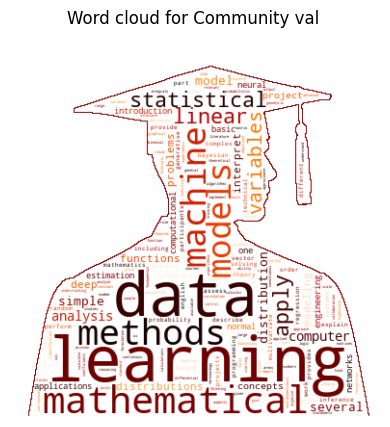


 Courses: 
 Computer Programming (Polytechnical Foundation)
Statistics (Polytechnical Foundation)
Mathematics 1b (Polytechnical Foundation)
Introduction to Machine Learning and Data Mining
Introduction to Mathematical Statistics
Mathematics 1a (Polytechnical foundation)
Mathematics 1b (Polytechnical Foundation)
Probability theory
Mathematics 1a (Polytechnical foundation)
Deep learning
Introduction to Mathematics and Technology
Advanced Machine Learning
Multivariate Statistics
Bayesian machine learning
Machine Learning Operations


In [94]:
new_dict = {}
new_dict['val'] = communities[96]

P = G.copy()
generate_wordcloud(P,new_dict, stop_words=stop_words, max_words=200)


In [ ]:
# Sort the communities by the number of values (courses) in descending order
sorted_communities = sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)

# Take the top 10 items
top_10_communities = dict(sorted_communities[:10])

# Show the top 10 communities
#generate_wordcloud(P,top_10_communities, stop_words)